**3D fitting**

We use the dataset produced by the data_preparation_HESS.

Objective: how to build a SkyModel and fit it on the data to determine the morphology and spectral shape of the source.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys, logging
import gammapy
import numpy as np
import astropy
import regions

from pathlib import Path
from scipy.stats import norm,chi2
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
from regions import read_ds9, CircleSkyRegion,RectangleSkyRegion

from gammapy.data import DataStore
from gammapy.analysis import Analysis, AnalysisConfig

from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
    MapDatasetOnOff,
    MapDataset
)
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    Model, 
    Models,
    FoVBackgroundModel,
    GaussianSpatialModel,
    PointSpatialModel,
    DiskSpatialModel,
    TemplateSpatialModel,
    Model
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    MapDatasetMaker,
    FoVBackgroundMaker
    )
from gammapy.modeling import Fit
from gammapy.estimators import FluxPoints,FluxPointsEstimator,ExcessMapEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.catalog import CATALOG_REGISTRY

import scipy
log = logging.getLogger(__name__)

In [2]:
# path for the files : codes, xml, reg...
files_path = "/home/pchambery/These_Oct_Mars_2020/hessJ1825_map5X5/gammapy_hessJ1825/"

In [3]:
# Read dataset from disk:  the result of the data reduction, a stacked MapDataset
filename = "/mnt/hgfs/dataset/hess/hessJ1825_dataset_05-20/hessJ1825-hap_fr_he_stacked_normtilt.fits.gz"
stacked = MapDataset.read(filename)

In [4]:
print(stacked)

MapDataset
----------

  Name                            : CZ7U0YWT 

  Total counts                    : 476324 
  Total background counts         : 429295.62
  Total excess counts             : 47028.38

  Predicted counts                : 429295.66
  Predicted background counts     : 429295.62
  Predicted excess counts         : nan

  Exposure min                    : 1.25e+02 m2 s
  Exposure max                    : 5.31e+11 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 761929 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [5]:
position = SkyCoord.from_name("HESS J1825-137")
geom = stacked._geom

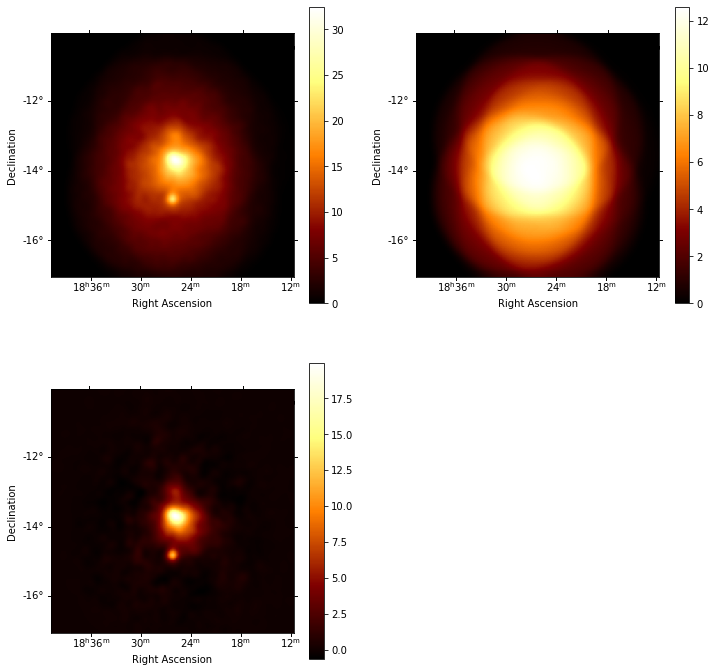

In [6]:
# check data
# plot total counts, background and residuals taking into account the stacked normalized backgrounds
plt.figure(figsize=(12,12))
ax1=plt.subplot(221, projection=stacked.counts.geom.wcs)
stacked.counts.sum_over_axes().smooth(0.1 * u.deg).plot(ax=ax1,  add_cbar=True) # smoothing in 
#stacked.counts.sum_over_axes().plot(ax=ax1,  add_cbar=True) # no smoothing in counts
ax2=plt.subplot(222, projection=stacked.counts.geom.wcs)
stacked.background.sum_over_axes().smooth(0.1 * u.deg).plot(ax=ax2,  add_cbar=True)
ax3=plt.subplot(223, projection=stacked.counts.geom.wcs)
residuals = stacked.residuals().sum_over_axes().smooth(0.1 * u.deg).plot(ax=ax3, add_cbar=True)

In [7]:
# First two energy bins are below the safe threshold defined in the data reduction step.
# To avoid any problem just above the threshold, we remove the third energy bin by defining a fit mask.
# Convert the numpy array into a map
#mask_data_1 = stacked.counts.geom.energy_mask(2.0*u.TeV, 100.0 *u.TeV)
#mask_energy = Map.from_geom(geom=stacked.counts.geom, data=mask_data_1)

# exclusion mask with a ds9 file to not fit certain sources
# Convert the numpy array into a map
excluded_regions = read_ds9(files_path + 'LS5039_6boxes_maskexclusion_hap-fr-he_ds9.reg')
mask_data_2 = geom.region_mask(excluded_regions, inside=False)
exclusion_mask = Map.from_geom(geom=geom, data=mask_data_2)

# total mask
#full_mask = mask_energy * exclusion_mask
#stacked.mask_fit = full_mask
stacked.mask_fit = exclusion_mask
#stacked.mask_fit = mask_energy

print(stacked)

MapDataset
----------

  Name                            : CZ7U0YWT 

  Total counts                    : 476324 
  Total background counts         : 429295.62
  Total excess counts             : 47028.38

  Predicted counts                : 429295.66
  Predicted background counts     : 429295.62
  Predicted excess counts         : nan

  Exposure min                    : 1.25e+02 m2 s
  Exposure max                    : 5.31e+11 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 710108 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [8]:
print(stacked.models)

None


## First perform a background only fit

In [9]:
bkg_model = FoVBackgroundModel(dataset_name=stacked.name)

In [10]:
bkg_model.spectral_model.norm.value

1.0

In [11]:
bkg_model.spectral_model.tilt.value

0.0

In [12]:
# frees bkg parameters to fit them
bkg_model.spectral_model.norm.frozen = False
bkg_model.spectral_model.tilt.frozen = False

In [13]:
# Add the source model to the list of models on the dataset
models = Models([bkg_model])
stacked.models = models

In [14]:
%%time
fit = Fit([stacked])

CPU times: user 40 µs, sys: 6 µs, total: 46 µs
Wall time: 47.9 µs


In [15]:
result_1 = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 6.997E+05               |      Ncalls=35 (35 total)      |
| EDM = 0.000583 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


In [16]:
print(result_1)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 35
	total stat : 699668.59



In [17]:
result_1.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str3,float64,float64,bool,float64
norm,1.0160e+00,,nan,nan,False,3.728e-03
tilt,-1.2315e-02,,nan,nan,False,2.706e-03
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


In [18]:
L1 = stacked.stat_sum()
print(L1)

699668.5926467698


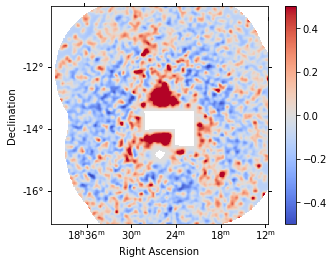

In [19]:
# The residuals maps after the fit
stacked.plot_residuals_spatial(method="diff/sqrt(model)",smooth_radius="0.05 deg",vmin=-0.5,vmax=0.5)

### Define a SkyModel to fit all the sources except HESSJ1825

In [ ]:
# test : add energy mask
#mask_data_2 = stacked.counts.geom.energy_mask(2.0*u.TeV, 20.0 *u.TeV)
#mask_energy = Map.from_geom(geom=stacked.counts.geom, data=mask_data_2)
#boxenergy_template = mask_energy * box_template

# test : mask on a excess map
estimator_005 = ExcessMapEstimator(correlation_radius=0.05*u.deg)
res_good = estimator_005.run(stacked)
excess_map = res_good["excess"]

# Define the geometry of the Map
energy_axis = stacked.counts.geom.axes["energy"]
geom_image = geom.to_image().to_cube([energy_axis.squash()]) # to not have arithmetic pbs

# Define the box template and plot it
box_region = read_ds9(files_path + '1box_template_hap-fr-he_ds9.reg')
#box_template = Map.from_geom(geom=geom, data=template_data)
box_template = Map.from_geom(geom_image)
box_template.data = geom_image.region_mask(box_region, inside=True)
box_template.sum_over_axes().plot()

# Creation spatial box and plot
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=excess_map.geom.wcs)
ax1.set_title("Box template excess map")
box=excess_map * box_template
box.plot(ax=ax1, add_cbar=True)

# test : mask on residuals map
#residuals = stacked.residuals().sum_over_axes().smooth(0.05 * u.deg).plot(cmap="afmhot", add_cbar=True)

/home/pchambery/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [ ]:
# To save masks to disk
box_int = box.copy()
box_int.data = box_int.data.astype(int)
box_int.write("1box_template_hap-fr-he_ds9.fits", overwrite="True")
#box_template_int = box_template.copy()
#box_template_int.data = box_template_int.data.astype(int)
#box_template.write("1box_template_hap-fr-he_ds9.fits", overwrite="True")

In [ ]:
# source : hessJ1825 spatial box
box_filename = "1box_template_hap-fr-he_ds9.fits"
box_map = Map.read(box_filename)
spatial_model_hessJ1825_box = TemplateSpatialModel(box_map)
#spatial_model_hessJ1825_box.plot(add_cbar=True)

In [ ]:
# source : hessJ1825 spectral
spectral_model_hessJ1825_box = PowerLawSpectralModel(
    amplitude=4e-13 * u.Unit("cm-2 s-1 TeV-1"), # amplitude for 1 source divided by 6 (for 6 boxes)
    index=1.67,
    reference=1.0 * u.Unit("TeV"),
)

model1 = SkyModel(
    spatial_model=spatial_model_hessJ1825_box,
    spectral_model=spectral_model_hessJ1825_box,
    name="hessJ1825_box",
)

# source : hessJ1826, nearest neighbor extended
spatial_model_hessJ1826 = GaussianSpatialModel(
    lon_0="276.50 deg", lat_0="-13.03 deg", sigma="0.17 deg", frame="icrs"
)

spectral_model_hessJ1826 = PowerLawSpectralModel(
    amplitude=6.66e-13 * u.Unit("cm-2 s-1 TeV-1"),
    index=1.20,
    reference=1.0 * u.Unit("TeV"),
)

model3 = SkyModel(
    spatial_model=spatial_model_hessJ1826,
    spectral_model=spectral_model_hessJ1826,
    name="hessJ1826",
)

In [ ]:
models = Models([model1, bkg_model, model3])
stacked.models = models

In [ ]:
# Freeze one hessJ1825 box parameters
spectral_model_hessJ1825_box.amplitude.frozen = False
spectral_model_hessJ1825_box.amplitude.min = 0
spectral_model_hessJ1825_box.amplitude.max = 1e-10
spectral_model_hessJ1825_box.index.frozen = False
spectral_model_hessJ1825_box.reference.frozen = True

# Freeze hessJ1826 parameters
spatial_model_hessJ1826.lon_0.frozen = True
spatial_model_hessJ1826.lat_0.frozen = True
spatial_model_hessJ1826.sigma.frozen = True

spectral_model_hessJ1826.amplitude.frozen = False
spectral_model_hessJ1826.amplitude.min = 0
spectral_model_hessJ1826.amplitude.max = 1e-10
spectral_model_hessJ1826.index.frozen = True
spectral_model_hessJ1826.reference.frozen = True

# free the background parameters 
bkg_model.spectral_model.norm.value = 1.0
bkg_model.spectral_model.tilt.value = 0.15

bkg_model.spectral_model.norm.frozen = False
bkg_model.spectral_model.tilt.frozen = False

In [ ]:
print(stacked.models)

### Fit the first spectral model

In [ ]:
%%time
fit = Fit([stacked])
result_2 = fit.run(optimize_opts={"print_level": 1})

In [ ]:
print(result_2)

In [ ]:
result_2.parameters.to_table()

In [ ]:
L2 = stacked.stat_sum() # stat_sum() give the total likelihood with the current parameters
print(L2)

In [ ]:
# The residual maps after the fit
stacked.plot_residuals_spatial(method="diff/sqrt(model)",smooth_radius="0.05 deg",vmin=-0.5,vmax=0.5)
plt.grid()

In [ ]:
print('TS Detection = ', L1-L2)